# Suavizado de la señal de tráfico de un servidor web

## Resumen
El monitoreo del tráfico de red en un servidor web es una tarea necesaria para determinar si la cantidad de usuarios conectados simultáneamente excede la capacidad del equipo instalado. Cuando el sistema recibe más solicitudes de las que puede procesar produce tiempos de respuesta largos, lo que empeora la experiencia del usuario, y a largo plazo, incide en la pérdida de clientes. Para resolver este problema los administradores del sistema podrían instalar un balanceador de carga, aumentar el CPU y la memoria, u optimizar la base de datos; sin embargo, con un nivel de carga cambiante lo mejor que puede realizarse es implementar un sistema de generación de alertas automáticas para determinar los momentos en los que la señal de tiempo vs. número de conexiones establecidas excede el umbral definido. Esta técnica se conoce como umbralización y un ejemplo de este control usando un umbral de 7k solicitudes se presenta a continuación:

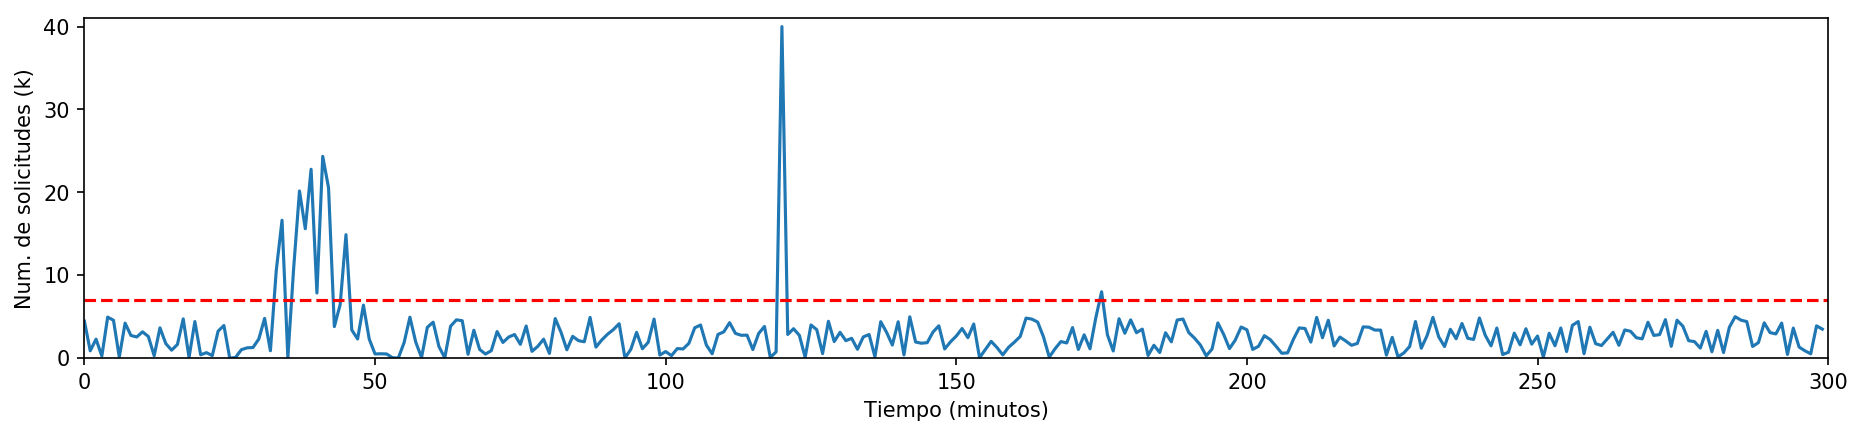

In [108]:
#%pylab inline
%matplotlib inline
import numpy as np;
N = 300
x = np.random.rand(N)*5
x[25:55] = np.multiply(x[25:55],5*np.hanning(30))
x[120] = 40
x[175] = 8
figure(figsize=(15, 3), dpi= 150, facecolor='w', edgecolor='k')
plot(x)
xlim([0,N])
ylim([0,41])
axhline(y=7, color='r', linestyle='--')
xlabel('Tiempo (minutos)')
ylabel('Num. de solicitudes (k)')
show()

Como puede apreciarse, los picos en los instantes 40, 120 y 175 son reconocidos como eventos indeseados y candidatos para la emisión de una alerta. Sin embargo, observando más de cerca el pico en el instante 175, se observa que este representa un evento transitorio que no representa una amenaza real pues tarda apenas unos pocos minutos y su amplitud no es tan alta. Esta es la razón por la que el método de umbralización suele acompañarse con otra técnica llamada media móvil (MA, por sus siglas en inglés), que permite realizar un "suavizado" de la señal de datos y que se define como sigue:
$$
y[n] = \frac{1}{M}\sum_{m=0}^{M}{x[n-m]},
$$
donde $M$ es la cantidad de vecinos anteriores. No se consideran los vecinos posteriores pues el procesamiento se realiza de manera causal. La implementación de la ecuación anterior usando 6 vecinos permite generar la siguiente señal:

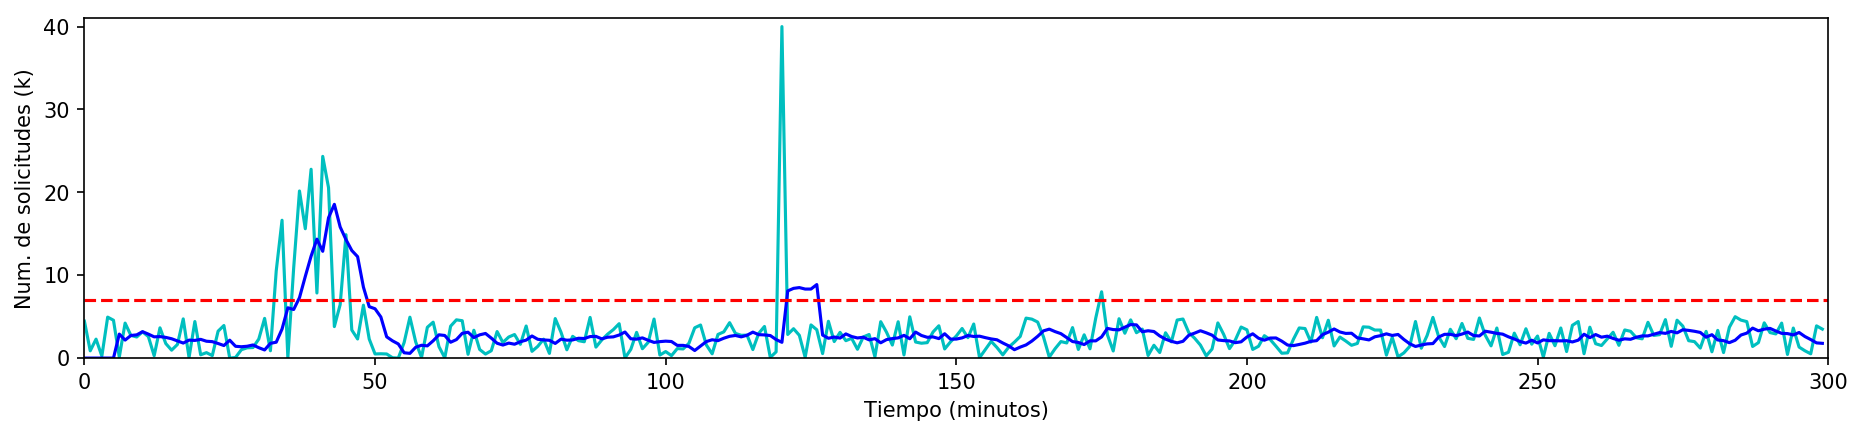

In [109]:
y = [0.0]*N
M=6
for n in range(M,N):
    y[n] = np.sum(x[n-M:n])/M
figure(figsize=(15, 3), dpi= 150, facecolor='w', edgecolor='k')
plot(x,'c')
plot(y,'b')
xlim([0,N])
ylim([0,41])
axhline(y=7, color='r', linestyle='--')
xlabel('Tiempo (minutos)')
ylabel('Num. de solicitudes (k)')
show()

Donde se observa que el pico en 175 a sido reducido y los eventos cerca 40 y 120 se mantienen por encima del umbral. Sin embargo, un efecto indeseado de la MA es que la señal filtrada presenta un desplazamiento temporal a la derecha, lo que puede ser un problema si se desea obtener alertas tempranas. 

Para implementar este suavizado de datos, aplicaciones como Grafana, ofrecen los famosos filtros de , que aunque son fáciles de implementar, producen un retraso de grupo, es decir, un desplazamiento temporal en el instante donde realmente ocurrieron los picos de actividad. 

%
1. ¿Cuál es el problema que plantea el paper?
2. ¿Por qué es un problema interesante o importante?
3. ¿Qué otras soluciones se han intentado para resolver este problema?
4. ¿Cuál es la solución propuesta por los autores?
5. ¿Qué tan exitosa es esta solución?
%

take into account that the number of neighbors you are using for the MA is significant enough to add a temporal delay, so you are sacrificing curve smoothness by temporal precision. MA has a linear phase distortion, meaning that even the low frequencies you want to preserve are affected with a temporal delay. If you use the IIR version of the MA (a.k.a. the leaky integrator or exponential moving average) you will have a very localized exponential distortion, and you will preserve curve smoothness and temporal precision. For graphite, how ever, you would need to create your own function. (edited)
Try `y[n]=lambda*y[n-1]+(1-lambda)*x[n]` where `lambda=(neighbors-1)/neighbors` and `x` is your noisy discrete signal, it shouldn't be difficult to implement with a little script in Python (https://graphite.readthedocs.io/en/latest/functions.html#function-plugins) 